# SOFIA Data Organization
After downloading the SOFIA DCS bundle to your working directory you will want to unzip it, which will produce a directory structure like this:

In [1]:
# perhaps insert a description of the filenaming convention?

You can choose to keep the `fits` files nested, or copy them into one directory.  If you are feeling particularly courageous, the following `bash` command will flatten the current directory structure for you.

```console
foo@bar:~$ find . -mindepth 3 -type f -exec cp -i '{}' . ';'
```

For the purpose of this basic analysis, though, let us dump all the files into one `sofia_data` directory:

# Data Structure

Using [astropy](http://docs.astropy.org/en/stable/), we can explore the data HAWC+ `fits` data cubes:

In [2]:
from astropy.io import fits

hawc_a = fits.open('sofia_data/F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits')
hawc_a.info()

Filename: sofia_data/F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU     572   (94, 114)   float64   
  1  ERROR I       1 ImageHDU        27   (94, 114)   float64   
  2  STOKES Q      1 ImageHDU        18   (94, 114)   float64   
  3  ERROR Q       1 ImageHDU        18   (94, 114)   float64   
  4  STOKES U      1 ImageHDU        18   (94, 114)   float64   
  5  ERROR U       1 ImageHDU        18   (94, 114)   float64   
  6  IMAGE MASK    1 ImageHDU        27   (94, 114)   float64   
  7  PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
 10  POL ANGLE     1 ImageHDU        18   (94, 114)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        18   (94, 114)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        18   (94, 114)   float

We can see here the data structure of the multi-extension `fits` files.  Each file contains 19 extensions which encapsulates all of the Stokes parameters in a single package.

## Stokes I
Stokes $I$---the zeroth extension in the `fits` file---represents the total intensity of the image, where $I^2 = Q^2 + U^2$.


Let us go ahead and plot this extension:

<IPython.core.display.Javascript object>


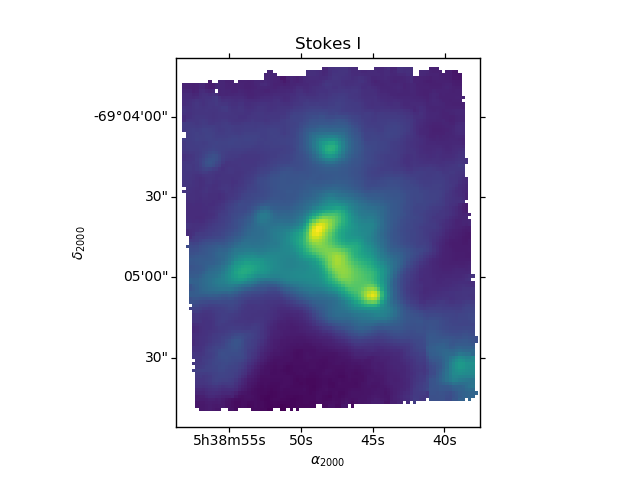

In [3]:
%matplotlib notebook
# ^jupyter magic for inline plots
import matplotlib.pyplot as plt
from astropy.wcs import WCS
import numpy as np

stokes_i = hawc_a['STOKES I']          # or hawc_a[0]
stokes_i.wcs = WCS(stokes_i.header)    # read the WCS information from the header
                                       #  and store it in stokes_i.wcs

plt.figure()
axi = plt.subplot(projection=stokes_i.wcs)
axi.imshow(stokes_i.data, origin='lower')

# FORMATTING
axi.set_title('Stokes I')
axi.set_xlabel(r'$\alpha_{2000}$')
axi.set_ylabel(r'$\delta_{2000}$')
axi.coords[0].set_major_formatter('hh:mm:ss')

## Stokes Q and U
Similarly, we can plot the Stokes Q and Stokes U images:

<IPython.core.display.Javascript object>


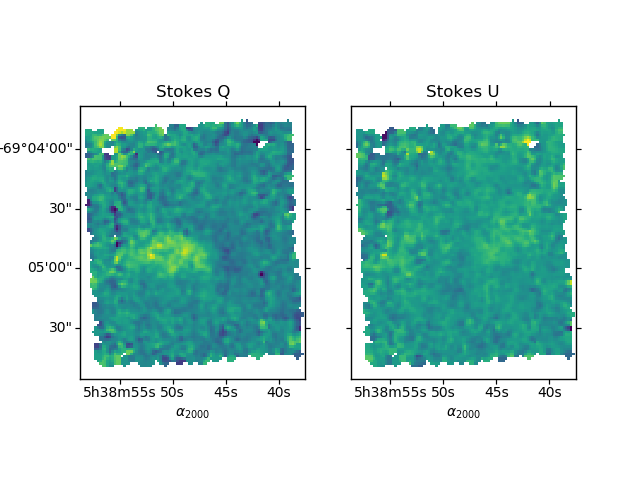

In [4]:
stokes_q = hawc_a['STOKES Q']
stokes_q.wcs = WCS(stokes_q.header)

stokes_u = hawc_a['STOKES U']
stokes_u.wcs = WCS(stokes_u.header)

plt.figure()
axq = plt.subplot(1,2,1, projection=stokes_q.wcs)
axu = plt.subplot(1,2,2, projection=stokes_u.wcs)
axq.imshow(stokes_q.data,origin='lower')
axu.imshow(stokes_u.data,origin='lower')

# FORMATTING
axq.set_title('Stokes Q')
axu.set_title('Stokes U')
axq.set_xlabel(r'$\alpha_{2000}$')
axq.set_ylabel(r'$\delta_{2000}$')
axu.set_xlabel(r'$\alpha_{2000}$')
axq.coords[0].set_major_formatter('hh:mm:ss')
axu.coords[0].set_major_formatter('hh:mm:ss')
axu.coords[1].set_ticklabel_visible(False)

## Polarized Intensity $I_p$
Level 4 HAWC+ additionally provides extensions with the polarization percentage ($p$), angle ($theta$), and their associated errors ($sigma$).

Percent polarization ($p$) and error ($sigma_p$) are calculated as:

$p = 100\sqrt{\left(\frac{Q}{I}\right)^2+\left(\frac{U}{I}\right)^2}$
$\sigma_p = \frac{100}{I}\sqrt{\frac{1}{(Q^2+U^2)}\left[(Q\,\sigma_Q)^2+(U\,\sigma_U)^2+2QU\,\sigma_{QU}\right]+\left[\left(\frac{Q}{I}\right)^2+\left(\frac{U}{I}\right)^2\right]\sigma_I^2-2\frac{Q}{I}\sigma_{QI}-2\frac{U}{I}\sigma_{UI}}$ .

Note that $p$ here represents the **percent** polarization as opposed to the more typical convention for $p$ as the **fractional** polarization.

Maps of these data are found in extensions 7 (PERCENT POL) and 9 (ERROR PERCENT POL).

Polarized intensity, $I_p$, can then be calculated as $I_p = \frac{I\times p}{100}$, which is included in extension 13 (POL FLUX).

Also included is the debiased polarization percentage ($p^\prime$) calculated as:

$p^\prime=\sqrt{p^2-\sigma_p^2}$, found in extension 8 (DEBIASED PERCENT POL).

We similarly define the debiased polarized intensity as $I_{p^\prime} = \frac{I\times p^\prime}{100}$, which is included in extension 15 (DEBIASED POL FLUX).

<IPython.core.display.Javascript object>


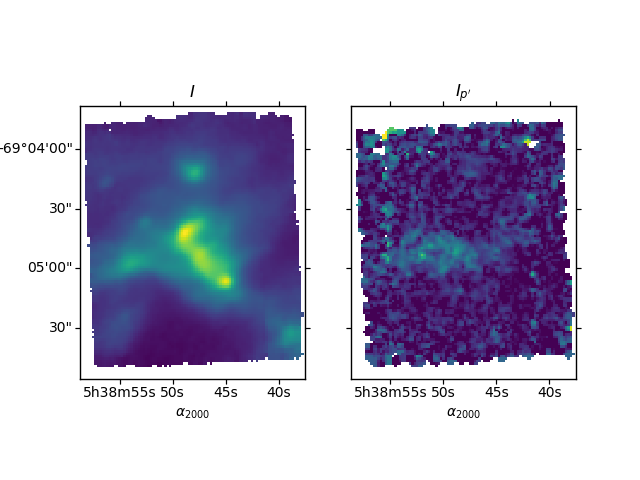

In [5]:
stokes_ip = hawc_a['DEBIASED POL FLUX']

fig = plt.figure()
axi = plt.subplot(1,2,1, projection=stokes_i.wcs)
axp = plt.subplot(1,2,2, projection=stokes_i.wcs)

axi.imshow( stokes_i.data, origin='lower')
axp.imshow(stokes_ip.data, origin='lower')

# FORMATTING
axi.set_title(r'$I$')
axp.set_title(r'$I_{p^\prime}$')
axi.set_xlabel(r'$\alpha_{2000}$')
axp.set_xlabel(r'$\alpha_{2000}$')
axi.set_ylabel(r'$\delta_{2000}$')
axi.coords[0].set_major_formatter('hh:mm:ss')
axp.coords[0].set_major_formatter('hh:mm:ss')
axp.coords[1].set_ticklabel_visible(False)

<IPython.core.display.Javascript object>


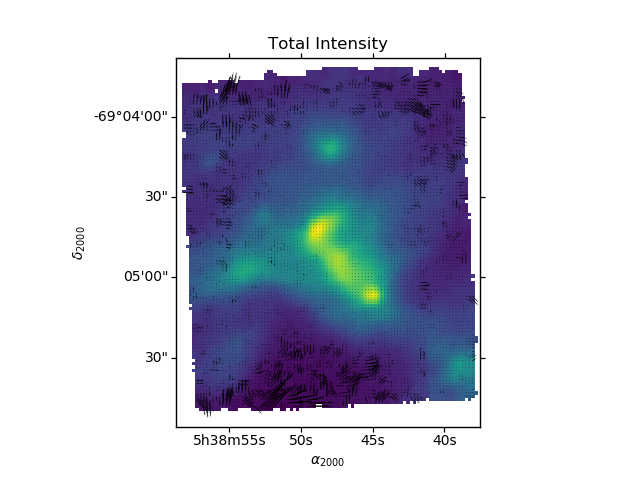

In [6]:
p = hawc_a['DEBIASED PERCENT POL']   # %
theta = hawc_a['ROTATED POL ANGLE']  # deg

plt.figure()
ax = plt.subplot(projection=stokes_i.wcs)
ax.imshow(stokes_i.data,origin='lower')

# Compute U,V  (x,y components of polarization arrow vectors)
U = p.data * np.cos(theta.data*np.pi/180)  # argument to numpy trig functions must be in radians
V = p.data * np.sin(theta.data*np.pi/180)

ax.quiver(U,V,headaxislength=0)

# FORMATTING
ax.set_title('Total Intensity')
ax.set_xlabel(r'$\alpha_{2000}$')
ax.set_ylabel(r'$\delta_{2000}$')
ax.coords[0].set_major_formatter('hh:mm:ss')
#ax.set_xlim([10,80])  # we zoom in a bit since the NaNs at the edges
#ax.set_ylim([10,80])  #  make the residuals blow up

One can certainly play around with some of the configuration options to `quiver`, such as scaling and masking out bad pixels. However, another option is binnng.  To visualize some of the larger scale vector flows, we can bin both the magnitude and angle of the polarization vectors.  We do this below by downsampling and summing the magnitudes ($p$) and averaging the angles of the vectors ($\theta$) in each bin.

<IPython.core.display.Javascript object>


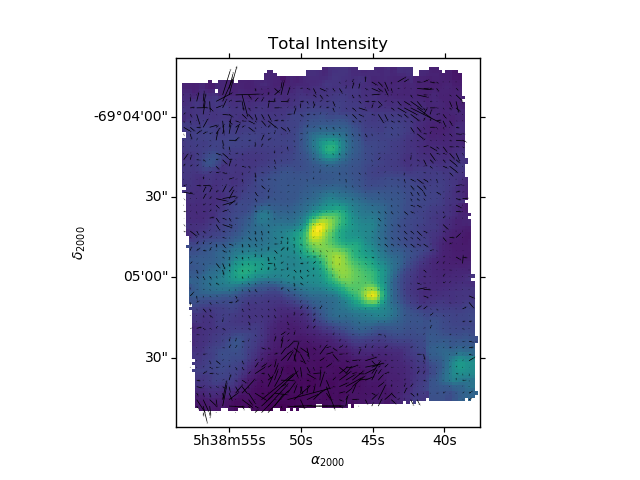

interactive(children=(IntSlider(value=2, description='block size', max=10, min=1), Output()), _dom_classes=('w…

In [7]:
from astropy.nddata.utils import block_reduce
from ipywidgets import interact, IntSlider
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure()
ax = plt.subplot(projection=stokes_i.wcs)
im = ax.imshow(stokes_i.data,origin='lower')

plotted = [im]

def rebin(n=2):
    # combine nxn pixels
    mag   = block_reduce(p.data,     block_size=n, func=np.nansum)
    angle = block_reduce(theta.data, block_size=n, func=np.nanmean)

    # Compute U,V  (x,y components of polarization arrow vectors)
    U = mag * np.cos(angle*np.pi/180)  # argument to numpy trig functions must be in radians
    V = mag * np.sin(angle*np.pi/180)

    # We cannot simply plot U and V anymore because these arrays are now much smaller
    #   than the background image
    # We can either downsample the Stokes I image as well, or we can alter the spacing of the 
    #   U and V vector coordinates

    Y,X = np.mgrid[0:mag.shape[0]*n:n,
                   0:mag.shape[1]*n:n]   ##!! [this is potentially misaligned?]

    ## this is just for the interactive widget
    if len(plotted) == 2:
        plotted.pop().remove()
        
    lines = ax.quiver(X,Y,U,V,headaxislength=0)
    plotted.append(lines)  # store for removing if widget is updated
    
widget = interact(rebin,
             n=IntSlider(min=1,max=10,step=1,value=2,description='block size'))

# FORMATTING
ax.set_title('Total Intensity')
ax.set_xlabel(r'$\alpha_{2000}$')
ax.set_ylabel(r'$\delta_{2000}$')
ax.coords[0].set_major_formatter('hh:mm:ss')

<IPython.core.display.Javascript object>


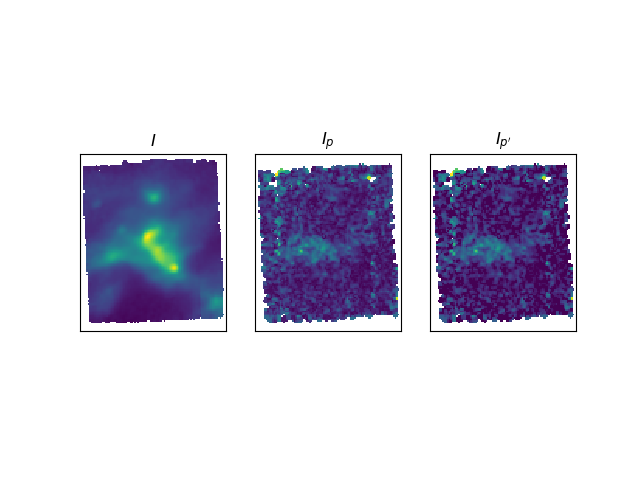

In [8]:
percent_p    = hawc_a['PERCENT POL']
percent_p_db = hawc_a['DEBIASED PERCENT POL']
stokes_ip    = stokes_i.data * percent_p.data/100
stokes_ip_db = stokes_i.data * percent_p_db.data/100 # I_p from the stokes_i extension
                                                     #   defined above and the percent
                                                     #   pol extensions (biased and debiased)
        
fig = plt.figure()
axi    = plt.subplot(1,3,1)#, projection=stokes_i.wcs)
axip   = plt.subplot(1,3,2)#, projection=stokes_i.wcs)
axipdb = plt.subplot(1,3,3)

axi.imshow(stokes_i.data, origin='lower')
axip.imshow(stokes_ip, origin='lower')

TEST = hawc_a['DEBIASED POL FLUX']
axipdb.imshow(TEST.data,origin='lower')

# FORMATTING
axi.   set_title(r'$I$')
axip.  set_title(r'$I_p$')
axipdb.set_title(r'$I_{p^\prime}$')
for ax in (axi,axip,axipdb):
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xlim([10,80])  # we zoom in a bit since the NaNs at the edges
    #ax.set_ylim([10,80])  #  make the residuals blow up

We note that the polarized intensity ($I_p$) and debiased polarized intensity ($I_{p^\prime}$) maps are very similar.

To explore the data cube, and also for a sanity check, let us compute $I_p$ ourselves in two ways: 1) from the Stokes $I$ and $p$ maps, and 2) from the $Q$ and $U$ maps (normalized by $I$).  These two maps *should* be equivalent.

<IPython.core.display.Javascript object>


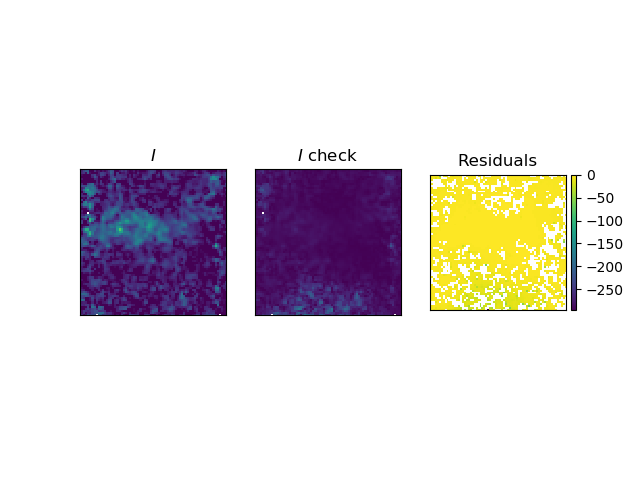

In [9]:
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

percent_p = hawc_a['DEBIASED PERCENT POL']
stokes_ip = stokes_i.data * percent_p.data/100           # I_p from the stokes_i extension
                                                         #   defined above and the percent
                                                         #   pol extension
        
stokes_ipcheck = np.hypot(stokes_q.data, stokes_u.data)  # == sqrt(Q**2 + U**2)
stokes_ipcheck /= stokes_i.data                          # I_p from Q and U extensions

residuals = (stokes_ip - stokes_ipcheck)/stokes_ip

fig = plt.figure()
axip = plt.subplot(1,3,1)#, projection=stokes_i.wcs)
axic = plt.subplot(1,3,2)#, projection=stokes_i.wcs)

# we add a third axis to hold the residuals
axir = plt.subplot(1,3,3)#, projection=stokes_i.wcs) # note the same WCS:
                                                   #   adding Q and U in quadrature above
                                                   #   works because HAWC+ images are aligned
                                                   #   in both pixel space and WCS
            
axip.imshow(stokes_ip, origin='lower')
axic.imshow(stokes_ipcheck, origin='lower')
rim = axir.imshow(residuals,origin='lower')

# COLORBAR
divider = make_axes_locatable(axir)
cax = divider.append_axes('right', size='4%', pad=0.05)
fig.colorbar(rim, cax=cax, orientation='vertical')

# FORMATTING
axip.set_title(r'$I$')
axic.set_title(r'$I$ check')
axir.set_title('Residuals')
for ax in (axip,axic,axir):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([10,80])  # we zoom in a bit since the NaNs at the edges
    ax.set_ylim([10,80])  #  make the residuals blow up
#axip.set_xlabel(r'$\alpha_{2000}$')
#axic.set_xlabel(r'$\alpha_{2000}$')
#axir.set_xlabel(r'$\alpha_{2000}$')
#axip.set_ylabel(r'$\delta_{2000}$')
#axip.coords[0].set_major_formatter('hh:mm:ss')
#axic.coords[0].set_major_formatter('hh:mm:ss')
#axir.coords[0].set_major_formatter('hh:mm:ss')
#axic.coords[1].set_ticklabel_visible(False)
#axir.coords[1].set_ticklabel_visible(False)